In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit,fsolve
from scipy.interpolate import interp1d
from numpy.polynomial import polynomial as poly

In [2]:
plt.rcParams['text.usetex'] = True

In [3]:
def get_values(filename):
    val_df = pd.read_csv(filename)
    val = np.transpose(val_df.to_numpy())
    return val

<h1>Histograms:</h1>

In [31]:
hist_16_lo = get_values('hist_data_16_0.9.csv')
hist_25_lo = get_values('hist_data_25_0.9.csv')
hist_40_lo = get_values('hist_data_40_0.9.csv')
hist_16_hi = get_values('hist_data_16_1.4.csv')
hist_25_hi = get_values('hist_data_25_1.4.csv')
hist_40_hi = get_values('hist_data_40_1.4.csv')

[]

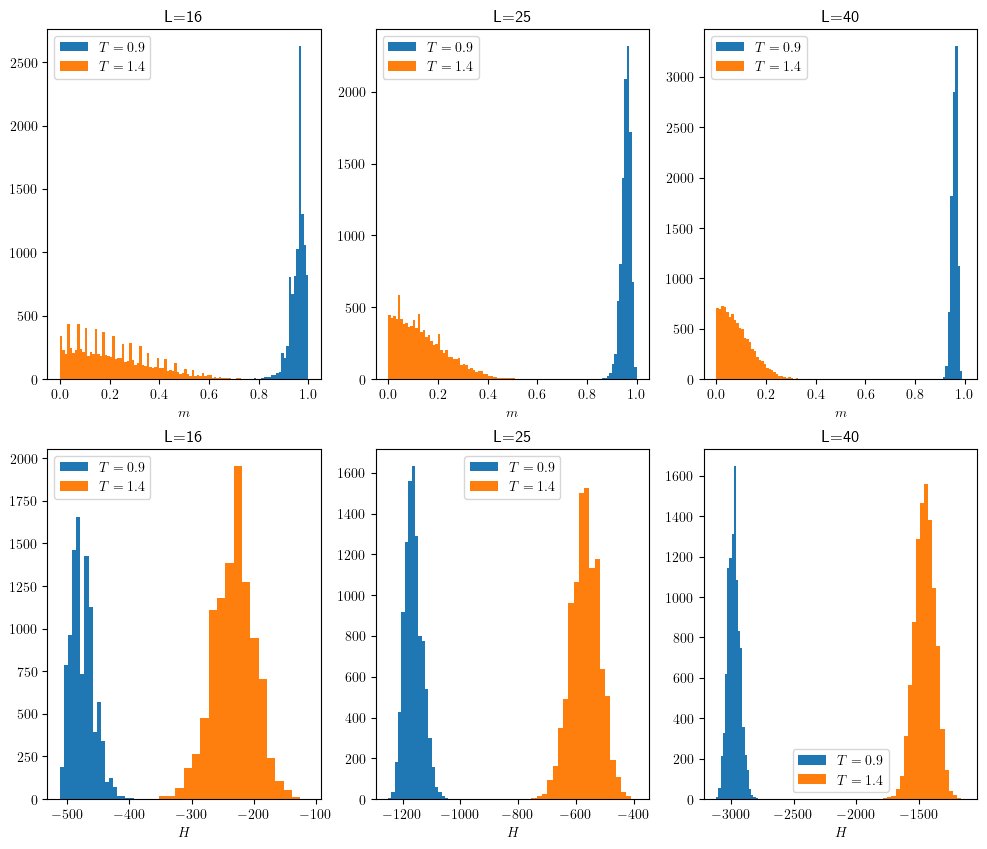

In [65]:
fig,axs = plt.subplots(2,3,figsize=(12,10))
#L=16
axs[0,0].hist(hist_16_lo[1],bins=100,range=(0,1),label='$T=0.9$')
axs[0,0].hist(hist_16_hi[1],bins=100,range=(0,1),label='$T=1.4$')
axs[0,0].legend()
axs[0,0].set_xlabel('$m$')
axs[0,0].set_title('L=16')
#L=25
axs[0,1].hist(hist_25_lo[1],bins=100,range=(0,1),label='$T=0.9$')
axs[0,1].hist(hist_25_hi[1],bins=100,range=(0,1),label='$T=1.4$')
axs[0,1].legend()
axs[0,1].set_xlabel('$m$')
axs[0,1].set_title('L=25')
#L=40
axs[0,2].hist(hist_40_lo[1],bins=100,range=(0,1),label='$T=0.9$')
axs[0,2].hist(hist_40_hi[1],bins=100,range=(0,1),label='$T=1.4$')
axs[0,2].legend()
axs[0,2].set_xlabel('$m$')
axs[0,2].set_title('L=40')

#L=16
axs[1,0].hist(hist_16_lo[2],bins=20,label='$T=0.9$')
axs[1,0].hist(hist_16_hi[2],bins=20,label='$T=1.4$')
axs[1,0].legend()
axs[1,0].set_xlabel('$H$')
axs[1,0].set_title('L=16')
#L=25
axs[1,1].hist(hist_25_lo[2],bins=20,label='$T=0.9$')
axs[1,1].hist(hist_25_hi[2],bins=20,label='$T=1.4$')
axs[1,1].legend()
axs[1,1].set_xlabel('$H$')
axs[1,1].set_title('L=25')
#L=40
axs[1,2].hist(hist_40_lo[2],bins=20,label='$T=0.9$')
axs[1,2].hist(hist_40_hi[2],bins=20,label='$T=1.4$')
axs[1,2].legend()
axs[1,2].set_xlabel('$H$')
axs[1,2].set_title('L=40')
plt.plot()

<h1>Two point function:</h1>

In [4]:
tpf_df = pd.read_csv('two_point_func_data_40_zoom_ex.csv')
tpf = np.transpose(tpf_df.to_numpy())
print(tpf)

[[ 1.        2.        3.        4.        5.        6.        7.
   8.        9.       10.       11.       12.       13.       14.
  15.       16.       17.       18.       19.       20.      ]
 [ 0.983436  0.759576  0.687176  0.654656  0.637416  0.629036  0.621716
   0.616536  0.613216  0.612896  0.611816  0.608716  0.606656  0.604336
   0.603396  0.600616  0.603676  0.603416  0.605276  0.601856]]


Estimated eta is 0.24939217560841512 ± 0.029533117859967997


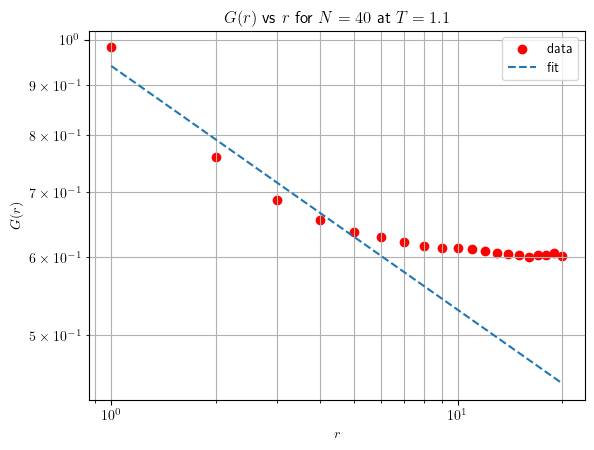

In [5]:
res = linregress(np.log(tpf[0][:6]),np.log(tpf[1][:6]))
print('Estimated eta is',-res.slope,'±',res.stderr)
plt.scatter(tpf[0][:],tpf[1][:],c='red',label='data')
plt.plot(tpf[0][:],np.exp(res.slope*np.log(tpf[0][:])+res.intercept),linestyle='--',label='fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$')
plt.ylabel(r'$G(r)$')
plt.title(r'$G(r)$ vs $r$ for $N=40$ at $T=1.1$')
plt.grid(True,which='both')
plt.legend()
plt.show()

<h1>Calculating $T_c$  and critical exponents using finite size scaling:</h1>

In [6]:
def fssa(Ls,Ts,ys,Tc_g,v_g,e_g,l_b,r_b,min_points,make_plot=False):
    xLs = np.array([(L**(1/v_g))*(T-Tc_g)/Tc_g for L,T in zip(Ls,Ts)])
    yLs = np.array([(L**(e_g/v_g))*y for L,y in zip(Ls,ys)])
    xLs_f_un = xLs.flatten()
    yLs_f_un = yLs.flatten()
    xLs_f,yLs_f = np.transpose([[x,y] for x,y in zip(xLs_f_un,yLs_f_un) if l_b<x<r_b])
    if xLs_f.shape[0] < min_points:
        return np.array([])
    xLs_fs = np.sort(xLs_f)
    yLs_fs = yLs_f[np.argsort(xLs_f)]
    fitted,stats = poly.Polynomial.fit(xLs_f,yLs_f,4,domain=[np.min(xLs_f),np.max(xLs_f)],full=True)
    if make_plot:
        plt.scatter(xLs_f,yLs_f,c='red',label='Collapsed data')
        plt.plot(xLs_fs,fitted(xLs_fs),c='blue',label=r'$4^{th}$ order poly fit')
        plt.xlabel(r'$\tau L^{1 / \nu}$')
        plt.ylabel(r'$\tau L^{\xi / \nu}$')
        plt.grid()
        plt.legend()
    return stats[0]/xLs_f.shape[0]

In [7]:
def search(Ls,Ts,ys,Tc_b,v_b,e_b,t_b,min_points):
    Tc_g = np.linspace(Tc_b[0],Tc_b[1],num=Tc_b[2],endpoint=False)
    v_g = np.linspace(v_b[0],v_b[1],num=v_b[2],endpoint=False)
    e_g = np.linspace(e_b[0],e_b[1],num=e_b[2],endpoint=False)
    Tc_est,v_est,e_est = None,None,None
    min_rss = 1e9
    for Tc in Tc_g:
        for v in v_g:
            for e in e_g:
                rss = fssa(Ls,Ts,ys,Tc,v,e,t_b[0],t_b[1],min_points)
                if rss.size == 0:
                    continue
                if rss[0] < min_rss:
                    Tc_est,v_est,e_est = Tc,v,e
                    min_rss = rss[0]
    return Tc_est,v_est,e_est,min_rss
    # _ = fssa(Ls,Ts,ys,Tc_est,v_est,gamma_est,l_b,r_b,min_points,make_plot=True)

In [8]:
#Common search parameters
Ls = [16,25,40]
Tc_b = (1.1,1.2,100)
v_b = (0.9,1.1,100)

<h2>Magnetisation:</h2>

In [9]:
mag_16_zoom = get_values('magnetisation_data_16_zoom_ex.csv')
mag_25_zoom = get_values('magnetisation_data_25_zoom_ex.csv')
mag_40_zoom = get_values('magnetisation_data_40_zoom_ex.csv')

[0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06
 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3 ]


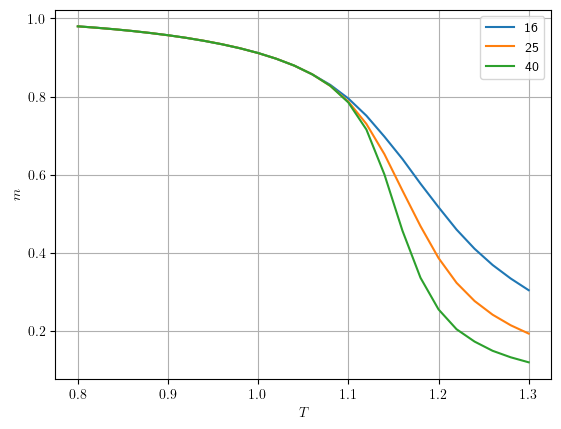

In [10]:
print(mag_16_zoom[0])
plt.plot(mag_16_zoom[0],mag_16_zoom[1],label='16')
plt.plot(mag_25_zoom[0],mag_25_zoom[1],label='25')
plt.plot(mag_40_zoom[0],mag_40_zoom[1],label='40')
plt.xlabel('$T$')
plt.ylabel(r'$m$')
plt.legend()
plt.grid(True,which='both')
plt.show()

In [11]:
mag_Ts = [mag_16_zoom[0],mag_25_zoom[0],mag_40_zoom[0]]
mag_ys = [mag_16_zoom[1],mag_25_zoom[1],mag_40_zoom[1]]
beta_b = (0,0.2,100)
mag_t_b = (0,2)
min_points = 10
search(Ls,mag_Ts,mag_ys,Tc_b,v_b,beta_b,mag_t_b,min_points)

(1.135, 0.936, 0.11800000000000001, 7.880405506892229e-07)

<h2>Susceptibility:</h2>

In [12]:
sus_16_zoom = get_values('susceptibility_data_16_zoom_ex.csv')
sus_25_zoom = get_values('susceptibility_data_25_zoom_ex.csv')
sus_40_zoom = get_values('susceptibility_data_40_zoom_ex.csv')

[0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06
 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3 ]


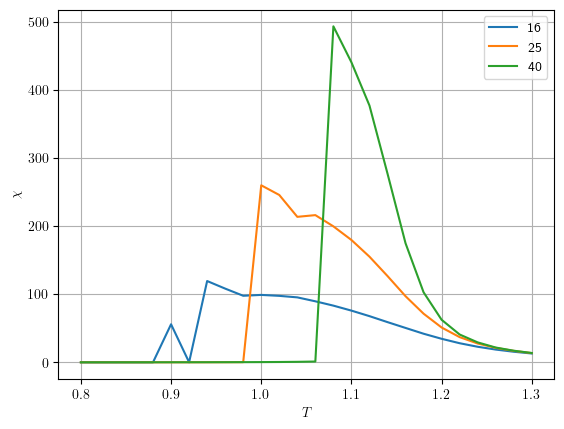

In [13]:
print(sus_16_zoom[0])
plt.plot(sus_16_zoom[0],sus_16_zoom[1],label='16')
plt.plot(sus_25_zoom[0],sus_25_zoom[1],label='25')
plt.plot(sus_40_zoom[0],sus_40_zoom[1],label='40')
plt.xlabel('$T$')
plt.ylabel(r'$\chi$')
plt.legend()
plt.grid(True,which='both')
plt.show()

In [14]:
sus_Ts = [sus_16_zoom[0],sus_25_zoom[0],sus_40_zoom[0]]
sus_ys = [sus_16_zoom[1],sus_25_zoom[1],sus_40_zoom[1]]
gamma_b = (-1.7,-1.8,100)
sus_t_b = (0,2)
min_points = 10
search(Ls,sus_Ts,sus_ys,Tc_b,v_b,gamma_b,sus_t_b,min_points)

(1.1340000000000001, 0.982, -1.734, 2.4487179076508365e-07)

<h2>Specific heat:</h2>

In [15]:
sh_16_zoom = get_values('specific_heat_data_16_zoom_ex.csv')
sh_25_zoom = get_values('specific_heat_data_25_zoom_ex.csv')
sh_40_zoom = get_values('specific_heat_data_40_zoom_ex.csv')

[0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06
 1.08 1.1  1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3 ]


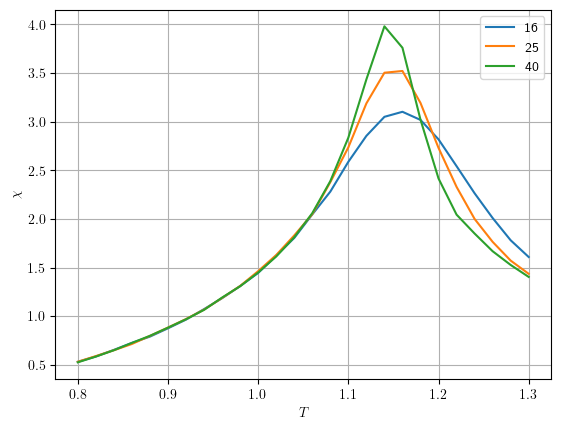

In [16]:
print(sh_16_zoom[0])
plt.plot(sh_16_zoom[0],sh_16_zoom[1],label='16')
plt.plot(sh_25_zoom[0],sh_25_zoom[1],label='25')
plt.plot(sh_40_zoom[0],sh_40_zoom[1],label='40')
plt.xlabel('$T$')
plt.ylabel(r'$\chi$')
plt.legend()
plt.grid(True,which='both')
plt.show()

In [17]:
sh_Ts = [sh_16_zoom[0],sh_25_zoom[0],sh_40_zoom[0]]
sh_ys = [sh_16_zoom[1],sh_25_zoom[1],sh_40_zoom[1]]
alpha_b = (-0.5,0.5,100)
sh_t_b = (0,1)
min_points = 10
search(Ls,sh_Ts,sh_ys,Tc_b,v_b,alpha_b,sh_t_b,min_points)

(1.135, 1.088, -0.31, 4.698719447425522e-05)

<h1>Critical exponents from curve fitting:</h1>

<h2>Susceptibility:</h2>

Estimated Tc for susceptibility is 1.10323


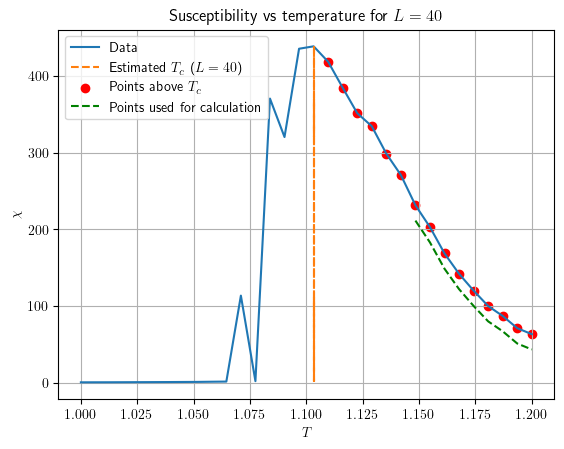

In [18]:
sus_40 = get_values('susceptibility_data_40_cr3.csv')
Tc_a=np.argmax(sus_40[1])+1
Tc_40=sus_40[0][Tc_a-1]
print('Estimated Tc for susceptibility is',Tc_40)
plt.plot(sus_40[0],sus_40[1],label='Data')
plt.plot([Tc_40]*sus_40.shape[1],sus_40[1][:],linestyle='--',label='Estimated $T_c$ ($L=40$)')
plt.scatter(sus_40[0][Tc_a:],sus_40[1][Tc_a:],c='red',label='Points above $T_c$')
plt.plot(sus_40[0][Tc_a+6:],sus_40[1][Tc_a+6:]-20,c='green',label='Points used for calculation',linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$\chi$')
plt.title('Susceptibility vs temperature for $L=40$')
plt.grid()
plt.legend()
plt.show()

Estimated gamma is 1.7544103459235123 ± 0.07261266365083612


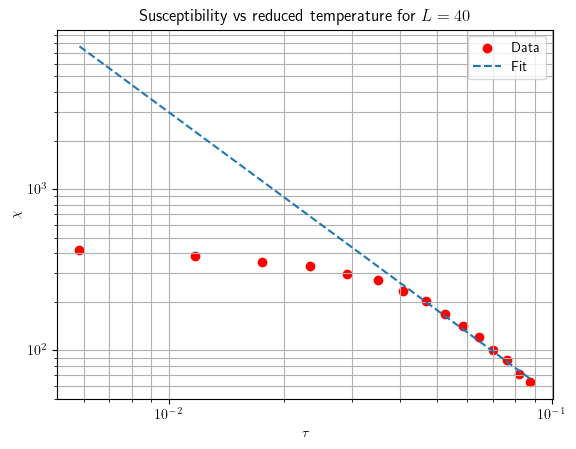

In [19]:
sus_40_rt = (sus_40[0]-Tc_40)/Tc_40
sus_res=linregress(np.log(sus_40_rt[Tc_a+6:]),np.log(sus_40[1][Tc_a+6:]))
print(r'Estimated gamma is',-sus_res.slope,'±',sus_res.stderr)
plt.scatter(sus_40_rt[Tc_a:],sus_40[1][Tc_a:],c='red',label='Data')
plt.plot(sus_40_rt[Tc_a:],np.exp(sus_res.slope*np.log(sus_40_rt[Tc_a:])+sus_res.intercept),label='Fit',linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\chi$')
plt.title(r'Susceptibility vs reduced temperature for $L=40$')
plt.grid(True,which='both')
plt.legend()
plt.show()

<h2>Magnetisation:</h2>

Estimated Tc for magnetisation is 1.10323


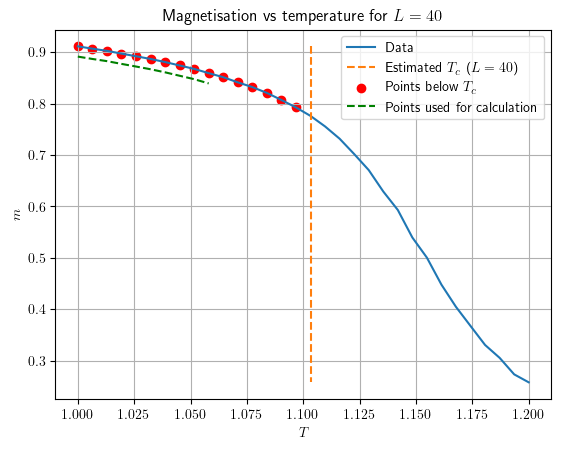

In [20]:
mag_40 = get_values('magnetisation_data_40_cr3.csv')
print('Estimated Tc for magnetisation is',Tc_40)
plt.plot(mag_40[0],mag_40[1],label='Data')
plt.plot([Tc_40]*mag_40.shape[1],mag_40[1][:],linestyle='--',label='Estimated $T_c$ ($L=40$)')
plt.scatter(mag_40[0][:Tc_a-1],mag_40[1][:Tc_a-1],c='red',label='Points below $T_c$')
plt.plot(mag_40[0][:10],mag_40[1][:10]-0.02,c='green',label='Points used for calculation',linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$m$')
plt.title('Magnetisation vs temperature for $L=40$')
plt.grid()
plt.legend()
plt.show()

Estimated beta is 0.07108506643612472 ± 0.00045838591555517807


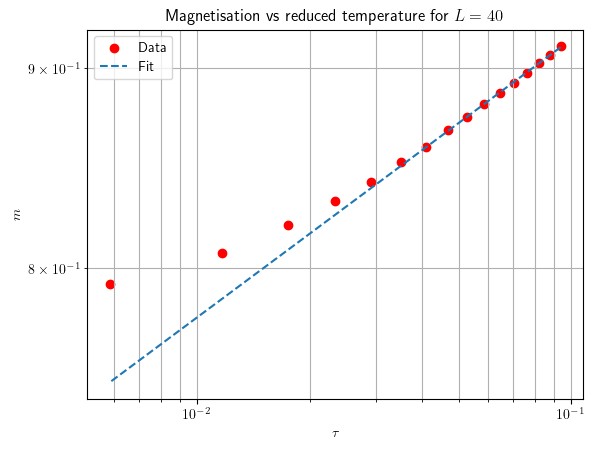

In [21]:
mag_40_rt = (mag_40[0]-Tc_40)/Tc_40
mag_res=linregress(np.log(-mag_40_rt[:10]),np.log(mag_40[1][:10]))
print(r'Estimated beta is',mag_res.slope,'±',mag_res.stderr)
plt.scatter(-mag_40_rt[:Tc_a-1],mag_40[1][:Tc_a-1],c='red',label='Data')
plt.plot(-mag_40_rt[:Tc_a-1],np.exp(mag_res.slope*np.log(-mag_40_rt[:Tc_a-1])+mag_res.intercept),label='Fit',linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$m$')
plt.title(r'Magnetisation vs reduced temperature for $L=40$')
plt.grid(True,which='both')
plt.legend()
plt.show()

<h2>Specific heat:</h2>

Estimated Tc for specific heat is 1.14839


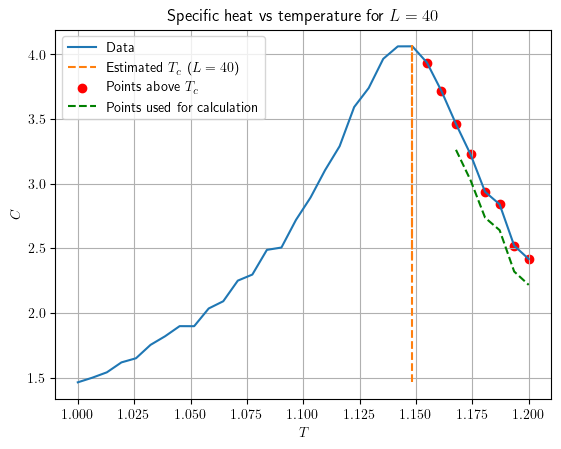

In [22]:
sh_40 = get_values('specific_heat_data_40_cr3.csv')
Tc_a_sh=np.argmax(sh_40[1])+1
Tc_40_sh=sh_40[0][Tc_a_sh-1]
print('Estimated Tc for specific heat is',Tc_40_sh)
plt.plot(sh_40[0],sh_40[1],label='Data')
plt.plot([Tc_40_sh]*sh_40.shape[1],sh_40[1][:],linestyle='--',label='Estimated $T_c$ ($L=40$)')
plt.scatter(sh_40[0][Tc_a_sh:],sh_40[1][Tc_a_sh:],c='red',label='Points above $T_c$')
plt.plot(sh_40[0][Tc_a_sh+2:],sh_40[1][Tc_a_sh+2:]-0.2,c='green',label='Points used for calculation',linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$C$')
plt.title('Specific heat vs temperature for $L=40$')
plt.grid()
plt.legend()
plt.show()

Estimated alpha is -0.37309420777242963 ± 0.033562331552317165


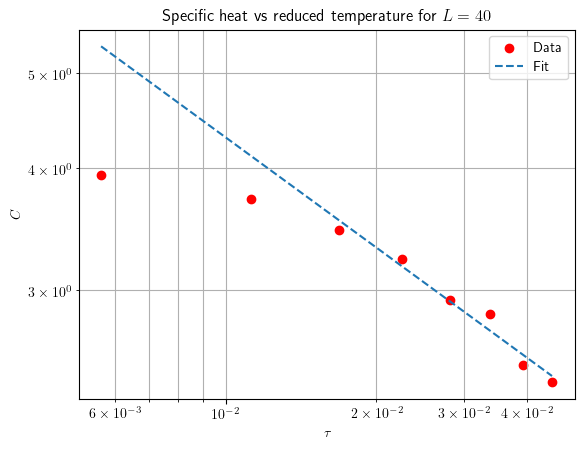

In [30]:
sh_40_rt = (sh_40[0]-Tc_40_sh)/Tc_40_sh
sh_res=linregress(np.log(sh_40_rt[Tc_a_sh+2:]),np.log(sh_40[1][Tc_a_sh+2:]))
print(r'Estimated alpha is',sh_res.slope,'±',sh_res.stderr)
plt.scatter(sh_40_rt[Tc_a_sh:],sh_40[1][Tc_a_sh:],c='red',label='Data')
plt.plot(sh_40_rt[Tc_a_sh:],np.exp(sh_res.slope*np.log(sh_40_rt[Tc_a_sh:])+sh_res.intercept),label='Fit',linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$C$')
plt.title(r'Specific heat vs reduced temperature for $L=40$')
plt.grid(True,which='both')
plt.legend()
plt.show()

<h1>Calculating $T_c$ using Binder cumulant:</h1>

In [24]:
bc_16 = get_values('binder_cumulant_data_16_zoom_ex.csv')
bc_25 = get_values('binder_cumulant_data_25_zoom_ex.csv')
bc_40 = get_values('binder_cumulant_data_40_zoom_ex.csv')

In [25]:
interp_16 = interp1d(bc_16[0],bc_16[1])
interp_25 = interp1d(bc_25[0],bc_25[1])
interp_40 = interp1d(bc_40[0],bc_40[1])

In [26]:
def difference(x,spl1,spl2):
    return np.abs(spl1(x)-spl2(x))

In [27]:
Tc_16_25 = fsolve(difference,1.134,(interp_16,interp_25),maxfev=1000)
Tc_25_40 = fsolve(difference,1.134,(interp_25,interp_40),maxfev=1000)
Tc_16_40 = fsolve(difference,1.134,(interp_16,interp_40),maxfev=1000)

In [28]:
Tc_est = np.mean([Tc_16_25,Tc_25_40,Tc_16_40])
print('Estimated Tc is',Tc_est)

Estimated Tc is 1.1319824956428717


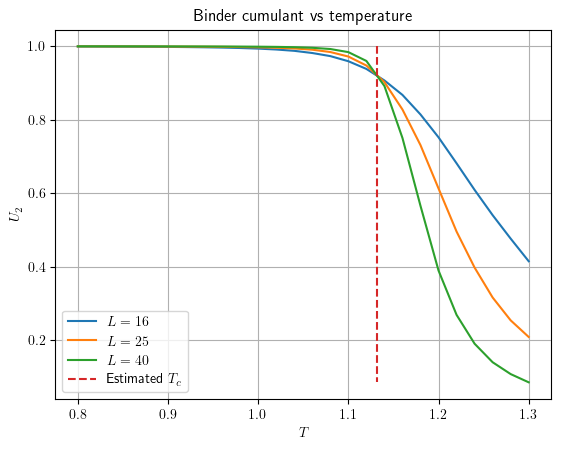

In [29]:
plt.plot(bc_16[0],1.5*(1-bc_16[1]/3),label='$L=16$')
plt.plot(bc_25[0],1.5*(1-bc_25[1]/3),label='$L=25$')
plt.plot(bc_40[0],1.5*(1-bc_40[1]/3),label='$L=40$')
plt.plot([Tc_est]*bc_40.shape[1],1.5*(1-bc_40[1]/3),label='Estimated $T_c$',linestyle='--')
plt.xlabel('$T$')
plt.ylabel('$U_2$')
plt.title('Binder cumulant vs temperature')
plt.grid()
plt.legend()
plt.show()